_Warning to the Jupyter reader: Gist/Github drop some formula lines and ignore MathJax backslash newlines; Latex doesn't render Greek characters in source blocks; and Notebook doesn't support \mathbb. The only export format that remotely works is HTML. What a clusterfuck._

In [1]:
# %matplotlib widget for interactive mode, or
# %matplotlib inline for print mode
%matplotlib inline

Introduction
---

This problem has been discussed on
[Computer Science Stack Exchange](https://cs.stackexchange.com/questions/127815). To recap:

There are up to 25 nodes, each representing a
[Terraria](https://en.wikipedia.org/wiki/Terraria) NPC's home location. These locations can be optimized based on a collection of cost factors. All factors are cost multipliers (higher is worse). Distances are discrete integers. None of the factors are continuous, and none are differentiable in space since they are all piece-wise. As a result, something like Gradient Descent is not possible without continuous approximation.

The 2D coordinates of each node are discrete and - for these purposes - unbounded. Since there are 25 nodes, there are 50 integer variables (xy for each node) to optimize. The hope is that even though there are no bounds, there will be enough sub-1.0 factors to have the optimization converge rather than force the nodes to fly apart.

In most modes of this optimization problem there are also between 2-3 biome regions extending out infinitely from the origin separated by straight lines. Each biome exactly encompasses one or more Cartesian quadrants. Each imposes a fixed cost or benefit to each node, but in the ideal case this cost does not change the "farther into the biome" a node gets. If I get the base optimization working well enough for a given biome configuration, I might expand this to selection of a biome configuration, for which there are currently 46 possibilities.


Simple Pair Costs
---

In the ideal (discrete) case, simple cost factors such as NPC pair relationships mentioned in the
[wiki](https://terraria.gamepedia.com/NPCs#Happiness):

> - For each Loved NPC within 25 tiles: 90%
> - For each Liked NPC within 25 tiles: 95%
> - For each Disliked NPC within 25 tiles: 105%
> - For each Hated NPC within 25 tiles: 110%

can be represented by a modified Heaviside function for each other node, e.g.:

$$
\mu = 1 + (1.05 - 1) H(25 - d)
$$

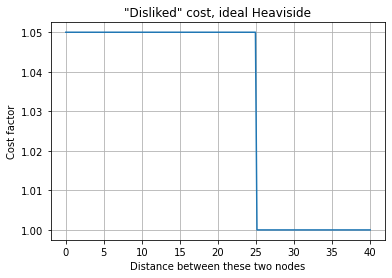

In [2]:
import numpy as np
import matplotlib.pyplot as plt

d = np.linspace(0, 40, 200)
μ = 1 + (1.05 - 1)*np.heaviside(25 - d, 0.5)
plt.figure(1)
plt.plot(d, μ)
plt.title('"Disliked" cost, ideal Heaviside')
plt.xlabel('Distance between these two nodes')
plt.ylabel('Cost factor')
plt.grid()
plt.show()

Sigmoid Approximation
---

However, this cost function is inconvenient, because it prevents any kind of continuous optimizer from working. It is non-differentiable and so standard techniques like gradient descent will not work. Instead, the suggested approach is to make a continuous sigmoid approximation. Increasing values of $\alpha$ will improve the approximation:

$$
\mu = 1 + \lim_{\alpha \to \infty} 
\frac {1.05 - 1}
{1 + e^{\alpha (d - 25)}}
$$

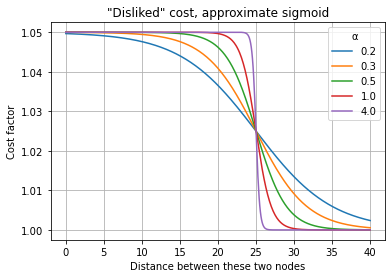

In [3]:
α = np.array([0.2, 0.3, 0.5, 1, 4], ndmin=2)
d = np.array(np.linspace(0, 40, 500), ndmin=2).T
μ = 1 + (1.05 - 1)/(1 + np.exp(α*(d - 25)))
plt.figure(2)
plt.plot(d, μ)
plt.title('"Disliked" cost, approximate sigmoid')
plt.xlabel('Distance between these two nodes')
plt.ylabel('Cost factor')
plt.legend(α.flatten(), title='α')
plt.grid()
plt.show()

Biome costs
---

Biome costs will be more complex:

> - Located in a Loved biome: 90%
> - Located in a Liked biome: 95%
> - Located in a Disliked biome: 105%
> - Located in a Hated biome: 110%

because they require a two-dimensional cost function. The cost function depends on the calculated quadrant:

$$
\theta \in \text{I}, 0 \le \theta < 4
$$

$$
\theta=\mod\left(
   \left\lfloor \frac {2 \text{atan2}(y,x)} \pi \right\rfloor,
   4
\right)
$$

or as a piece-wise function,

$$
\theta = \begin{cases}
  0  & x \ge 0, y \ge 0 \\
  1  & x <   0, y \ge 0 \\
  2  & x <   0, y <   0 \\
  3  & x \ge 0, y <   0 \\
\end{cases}
$$

$$b_{\theta} \in \text{R}, b_{\theta} > 0$$

For the ideal case,

$$\mu = b_{\theta}$$

For the approximated case, the cost factor must rely on all four quadrants:

$$
s_x(\theta) = \sqrt{2} \cos \frac {\pi(\theta+0.5)} 2 
= (+1, -1, -1, +1)
$$

$$
s_y(\theta) = \sqrt{2} \sin \frac {\pi(\theta+0.5)} 2 
= (+1, +1, -1, -1)
$$

$$
\mu(x, y) = \prod_{\theta=0}^3
\left(1 + 
    \lim_{\alpha \to \infty}
    \frac {b_\theta - 1}
    {
        \left(1 + e^{\alpha x s_x(\theta)} \right)
        \left(1 + e^{\alpha y s_y(\theta)} \right)
    }
\right)
$$

By example, for _liked_ , _hated_ , _neutral_ and _neutral_ biomes in quadrants I through IV respectively:

$$b = (0.95, 1.10, 1.00, 1.00)$$

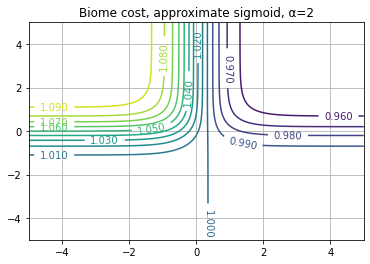

In [4]:
α = 2
axis = np.linspace(-5, 5, 200)
x, y = np.meshgrid(axis, axis)
b  = np.array((0.95,  1.10,  1.00,  1.00), ndmin=3)
sx = np.array((1, -1, -1,  1), ndmin=3)
sy = np.array((1,  1, -1, -1), ndmin=3)

μ = (
    1 + (b - 1)
    / (1 + np.exp(-α*sx * x[:, :, np.newaxis]))
    / (1 + np.exp(-α*sy * y[:, :, np.newaxis]))
).prod(axis=2)

plt.figure(3)
plot = plt.contour(x, y, μ, levels=15)
plt.title(f'Biome cost, approximate sigmoid, α={α}')
plt.clabel(plot)
plt.grid()
plt.show()

Crowding Cost
---

Multi-node interactions will also be more complex:

> Two or more other NPCs within 25 tiles (for each additional NPC): 104%

This implies:

- Calculate the Frobenius norm relative to all other nodes
- Find the closest node and remove it from the cost
- For all other nodes, calculate the product of sigmoid circles of diameter 25

For node $n$, and other nodes $m_i$, remove the node with this minimum for the Frobenius norm:

$$
\min_i \left|\middle|
m_i - n
\middle|\right|_F
$$

Then for the remaining nodes, calculate their radial sigmoid:

$$
\mu(x, y) = \prod_i \left(
    1 + \frac {1.04 - 1}
    {
        1 + e^{
            \alpha( ||m_i - n||_F - 25 )
        }
    }
\right)
$$

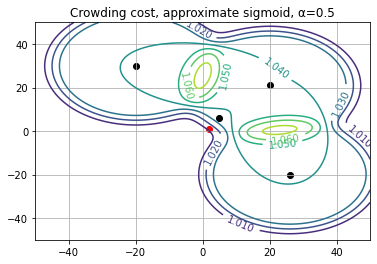

In [5]:
α = 0.5
this_node = np.array((2, 1))
other_nodes = np.array((
    (-20, 30),
    ( 20, 21),
    (  5,  6),
    ( 26,-20),
))
distances = np.linalg.norm(other_nodes - this_node, axis=1)
imin = np.argmin(distances)
nodes_for_dist = other_nodes[
    np.arange(len(other_nodes)) != imin
]

axis = np.linspace(-50, 50, 200)
x, y = np.meshgrid(axis, axis)
grid = np.stack((x, y), axis=2)[:, :, np.newaxis, :]
node_dists = np.linalg.norm(
    grid - nodes_for_dist, axis=3
)
μ = (
    1 + (1.04 - 1)/(
        1 + np.exp(α*(node_dists - 25))
    )
).prod(axis=2)

plt.figure(4)
plot = plt.contour(x, y, μ, levels=8)
plt.title(f'Crowding cost, approximate sigmoid, α={α}')
plt.clabel(plot)
plt.scatter(this_node[0], this_node[1], c='r')
plt.scatter(other_nodes[:, 0], other_nodes[:, 1], c='k')
plt.grid()
plt.show()

Complex Crowding Cost
---

> No more than one other NPC within 25 tiles and no more than three other NPCs (not counting the NPCs within 25 tiles) within 120 tiles: 90%